# Semantic Similarity with BERT

**Author:** [Mohamad Merchant](https://twitter.com/mohmadmerchant1)<br>
**Date created:** 2020/08/15<br>
**Last modified:** 2020/08/29<br>
**Description:** Natural Language Inference by fine-tuning BERT model on SNLI Corpus.

## Introduction

Semantic Similarity is the task of determining how similar
two sentences are, in terms of what they mean.
This example demonstrates the use of SNLI (Stanford Natural Language Inference) Corpus
to predict sentence semantic similarity with Transformers.
We will fine-tune a BERT model that takes two sentences as inputs
and that outputs a similarity score for these two sentences.

### References

* [BERT](https://arxiv.org/pdf/1810.04805.pdf)
* [SNLI](https://nlp.stanford.edu/projects/snli/)

## Setup

Note: install [HuggingFace](https://huggingface.co/) `transformers` via `pip install transformers` (version >= 2.11.0).

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.9 MB/s 
     |████████████████████████████████| 6.6 MB 46.3 MB/s 
     |████████████████████████████████| 596 kB 55.3 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')
model_dir = 'drive/MyDrive/ML/Exercise13_BERT/'

Mounted at /content/drive


## Configuration

In [4]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

## Load the Data

In [5]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  26.2M      0 --:--:-- --:--:-- --:--:-- 26.2M
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


In [6]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : \t\t{train_df.shape[0]}")
print(f"Total validation samples: \t{valid_df.shape[0]}")
print(f"Total test samples: \t\t{valid_df.shape[0]}")

Total train samples : 		100000
Total validation samples: 	10000
Total test samples: 		10000


Dataset Overview:

- sentence1: The premise caption that was supplied to the author of the pair.
- sentence2: The hypothesis caption that was written by the author of the pair.
- similarity: This is the label chosen by the majority of annotators.
Where no majority exists, the label "-" is used (we will skip such samples here).

Here are the "similarity" label values in our dataset:

- Contradiction: The sentences share no similarity.
- Entailment: The sentences have similar meaning.
- Neutral: The sentences are neutral.

Let's look at one sample from the dataset:

In [ ]:
train_df

,similarity,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present
...,...,...,...
99995,entailment,People with costumes are gathered in a wooded ...,people wear costumes
99996,contradiction,A girl with a black dress and big white bow st...,a man wearing high heels
99997,entailment,A girl with a black dress and big white bow st...,a girl standing
99998,neutral,A girl with a black dress and big white bow st...,a girl getting ready for photo shoot


In [ ]:
print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

Sentence1: A person on a horse jumps over a broken down airplane.
Sentence2: A person is at a diner, ordering an omelette.
Similarity: contradiction


## Preprocessing

In [ ]:
# We have some NaN entries in our train data, we will simply drop them.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Number of missing values
similarity    0
sentence1     0
sentence2     3
dtype: int64


Distribution of our training targets.

In [ ]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
entailment       33384
contradiction    33310
neutral          33193
-                  110
Name: similarity, dtype: int64


Distribution of our validation targets.

In [ ]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64


The value "-" appears as part of our training and validation targets.
We will skip these samples.

In [ ]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

One-hot encode training, validation, and test labels.

In [ ]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

## Keras Custom Data Generator
We define a generator class to create data batches used during either the trianing or the inference phase.

Besides random picking data and corresponding labels, this code perform tokenization using the selected BERT model.

Tokenization is the foremost step while modeling text data. Tokenization is performed on the corpus to obtain tokens. The following tokens are then used to prepare a vocabulary. Vocabulary refers to the set of unique tokens in the corpus. A vocabulary can be constructed by considering each unique token in the corpus or by considering the top K Frequently Occurring Words.

For more information about BERT tokenizer output format, see this *huggingface* [documentation page](https://huggingface.co/docs/transformers/glossary#model-inputs).

In [ ]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


## Build the model.

In [ ]:
# Encoded token ids from BERT tokenizer.
input_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="input_ids"
)
# Attention masks indicates to the model which tokens should be attended to.
attention_masks = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="attention_masks"
)
# Token type ids are binary masks identifying different sequences in the model.
token_type_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="token_type_ids"
)
# Loading pretrained BERT model.
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
# Freeze the BERT model to reuse the pretrained features without modifying them.
bert_model.trainable = False

bert_output = bert_model(
    input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
)
sequence_output = bert_output.last_hidden_state
pooled_output = bert_output.pooler_output

# Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
dense = tf.keras.layers.Dense(64, activation="relu")(sequence_output)
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(dense)  # Applying hybrid pooling approach
max_pool = tf.keras.layers.GlobalMaxPooling1D()(dense)      # Applying hybrid pooling approach
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)
output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
model = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids], outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

Create train and validation data generators

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

## Train the Model

Training is done only for the top layers to perform "feature extraction",
which will allow the model to use the representations of the pretrained model.

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  25/3121 [..............................] - ETA: 17:28 - loss: 1.3257 - acc: 0.3600

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  98/3121 [..............................] - ETA: 16:38 - loss: 1.1696 - acc: 0.3980

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 143/3121 [>.............................] - ETA: 16:19 - loss: 1.1350 - acc: 0.4106

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 187/3121 [>.............................] - ETA: 15:59 - loss: 1.1074 - acc: 0.4303

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 195/3121 [>.............................] - ETA: 15:56 - loss: 1.1018 - acc: 0.4359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 221/3121 [=>............................] - ETA: 15:44 - loss: 1.0841 - acc: 0.4480

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 261/3121 [=>............................] - ETA: 15:28 - loss: 1.0658 - acc: 0.4613

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 319/3121 [==>...........................] - ETA: 15:07 - loss: 1.0445 - acc: 0.4764

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 365/3121 [==>...........................] - ETA: 14:52 - loss: 1.0264 - acc: 0.4890

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 376/3121 [==>...........................] - ETA: 14:48 - loss: 1.0222 - acc: 0.4928

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 416/3121 [==>...........................] - ETA: 14:35 - loss: 1.0049 - acc: 0.5044

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 607/3121 [====>.........................] - ETA: 13:31 - loss: 0.9442 - acc: 0.5467

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 635/3121 [=====>........................] - ETA: 13:21 - loss: 0.9365 - acc: 0.5521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 734/3121 [======>.......................] - ETA: 12:49 - loss: 0.9163 - acc: 0.5649

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 800/3121 [======>.......................] - ETA: 12:27 - loss: 0.9035 - acc: 0.5731

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 831/3121 [======>.......................] - ETA: 12:17 - loss: 0.8992 - acc: 0.5758

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 998/3121 [========>.....................] - ETA: 11:23 - loss: 0.8719 - acc: 0.5929

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1044/3121 [=========>....................] - ETA: 11:09 - loss: 0.8649 - acc: 0.5973

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1046/3121 [=========>....................] - ETA: 11:08 - loss: 0.8645 - acc: 0.5975

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1123/3121 [=========>....................] - ETA: 10:43 - loss: 0.8556 - acc: 0.6032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1135/3121 [=========>....................] - ETA: 10:39 - loss: 0.8536 - acc: 0.6046

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1143/3121 [=========>....................] - ETA: 10:36 - loss: 0.8524 - acc: 0.6055

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1173/3121 [==========>...................] - ETA: 10:27 - loss: 0.8492 - acc: 0.6078

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1200/3121 [==========>...................] - ETA: 10:18 - loss: 0.8462 - acc: 0.6101

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1261/3121 [===========>..................] - ETA: 9:58 - loss: 0.8392 - acc: 0.6145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1265/3121 [===========>..................] - ETA: 9:57 - loss: 0.8385 - acc: 0.6149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1270/3121 [===========>..................] - ETA: 9:55 - loss: 0.8380 - acc: 0.6152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1372/3121 [============>.................] - ETA: 9:22 - loss: 0.8276 - acc: 0.6227

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1381/3121 [============>.................] - ETA: 9:20 - loss: 0.8264 - acc: 0.6234

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1422/3121 [============>.................] - ETA: 9:06 - loss: 0.8229 - acc: 0.6255

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1464/3121 [=============>................] - ETA: 8:53 - loss: 0.8192 - acc: 0.6280

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1551/3121 [=============>................] - ETA: 8:25 - loss: 0.8131 - acc: 0.6321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1568/3121 [==============>...............] - ETA: 8:20 - loss: 0.8116 - acc: 0.6328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1595/3121 [==============>...............] - ETA: 8:11 - loss: 0.8092 - acc: 0.6343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1611/3121 [==============>...............] - ETA: 8:06 - loss: 0.8080 - acc: 0.6350

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1641/3121 [==============>...............] - ETA: 7:56 - loss: 0.8057 - acc: 0.6369

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1642/3121 [==============>...............] - ETA: 7:56 - loss: 0.8057 - acc: 0.6369

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1647/3121 [==============>...............] - ETA: 7:54 - loss: 0.8056 - acc: 0.6370

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1680/3121 [===============>..............] - ETA: 7:44 - loss: 0.8040 - acc: 0.6378

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1683/3121 [===============>..............] - ETA: 7:43 - loss: 0.8039 - acc: 0.6379

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1710/3121 [===============>..............] - ETA: 7:34 - loss: 0.8024 - acc: 0.6389

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1720/3121 [===============>..............] - ETA: 7:31 - loss: 0.8017 - acc: 0.6392

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1753/3121 [===============>..............] - ETA: 7:20 - loss: 0.7991 - acc: 0.6409

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1775/3121 [================>.............] - ETA: 7:13 - loss: 0.7975 - acc: 0.6419

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1788/3121 [================>.............] - ETA: 7:09 - loss: 0.7965 - acc: 0.6424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1818/3121 [================>.............] - ETA: 6:59 - loss: 0.7944 - acc: 0.6437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1837/3121 [================>.............] - ETA: 6:53 - loss: 0.7926 - acc: 0.6446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1858/3121 [================>.............] - ETA: 6:46 - loss: 0.7911 - acc: 0.6457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1954/3121 [=================>............] - ETA: 6:15 - loss: 0.7856 - acc: 0.6496

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2013/3121 [==================>...........] - ETA: 5:56 - loss: 0.7824 - acc: 0.6518

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2019/3121 [==================>...........] - ETA: 5:54 - loss: 0.7818 - acc: 0.6521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2029/3121 [==================>...........] - ETA: 5:51 - loss: 0.7815 - acc: 0.6522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2138/3121 [===================>..........] - ETA: 5:16 - loss: 0.7776 - acc: 0.6549

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2219/3121 [====================>.........] - ETA: 4:50 - loss: 0.7749 - acc: 0.6568

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2270/3121 [====================>.........] - ETA: 4:34 - loss: 0.7729 - acc: 0.6583

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2278/3121 [====================>.........] - ETA: 4:31 - loss: 0.7727 - acc: 0.6584

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2310/3121 [=====================>........] - ETA: 4:21 - loss: 0.7711 - acc: 0.6595

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2365/3121 [=====================>........] - ETA: 4:03 - loss: 0.7694 - acc: 0.6605

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2449/3121 [======================>.......] - ETA: 3:36 - loss: 0.7651 - acc: 0.6631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2509/3121 [=======================>......] - ETA: 3:17 - loss: 0.7630 - acc: 0.6645

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2512/3121 [=======================>......] - ETA: 3:16 - loss: 0.7630 - acc: 0.6645

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2559/3121 [=======================>......] - ETA: 3:00 - loss: 0.7613 - acc: 0.6658

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2581/3121 [=======================>......] - ETA: 2:53 - loss: 0.7605 - acc: 0.6662

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2609/3121 [========================>.....] - ETA: 2:44 - loss: 0.7593 - acc: 0.6670

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2623/3121 [========================>.....] - ETA: 2:40 - loss: 0.7591 - acc: 0.6672

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2688/3121 [========================>.....] - ETA: 2:19 - loss: 0.7563 - acc: 0.6687

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2719/3121 [=========================>....] - ETA: 2:09 - loss: 0.7552 - acc: 0.6694

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2731/3121 [=========================>....] - ETA: 2:05 - loss: 0.7548 - acc: 0.6697

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2746/3121 [=========================>....] - ETA: 2:00 - loss: 0.7543 - acc: 0.6698

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2800/3121 [=========================>....] - ETA: 1:43 - loss: 0.7527 - acc: 0.6710

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2811/3121 [==========================>...] - ETA: 1:39 - loss: 0.7526 - acc: 0.6712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2848/3121 [==========================>...] - ETA: 1:27 - loss: 0.7516 - acc: 0.6719

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2910/3121 [==========================>...] - ETA: 1:07 - loss: 0.7492 - acc: 0.6733

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2912/3121 [==========================>...] - ETA: 1:07 - loss: 0.7490 - acc: 0.6734

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2950/3121 [===========================>..] - ETA: 55s - loss: 0.7485 - acc: 0.6738

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2998/3121 [===========================>..] - ETA: 39s - loss: 0.7471 - acc: 0.6744

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3028/3121 [============================>.] - ETA: 29s - loss: 0.7459 - acc: 0.6751

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3050/3121 [============================>.] - ETA: 22s - loss: 0.7456 - acc: 0.6753

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.7437 - acc: 0.6767

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will alwa

3121/3121 [==============================] - 1109s 352ms/step - loss: 0.7437 - acc: 0.6767 - val_loss: 0.5543 - val_acc: 0.7753
Epoch 2/2
  21/3121 [..............................] - ETA: 16:34 - loss: 0.6714 - acc: 0.7262

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  35/3121 [..............................] - ETA: 16:30 - loss: 0.6644 - acc: 0.7295

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  68/3121 [..............................] - ETA: 16:17 - loss: 0.6508 - acc: 0.7348

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 123/3121 [>.............................] - ETA: 16:02 - loss: 0.6444 - acc: 0.7350

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 147/3121 [>.............................] - ETA: 15:54 - loss: 0.6417 - acc: 0.7347

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 155/3121 [>.............................] - ETA: 15:51 - loss: 0.6437 - acc: 0.7361

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 176/3121 [>.............................] - ETA: 15:45 - loss: 0.6439 - acc: 0.7367

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 216/3121 [=>............................] - ETA: 15:32 - loss: 0.6459 - acc: 0.7351

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 225/3121 [=>............................] - ETA: 15:29 - loss: 0.6476 - acc: 0.7347

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 259/3121 [=>............................] - ETA: 15:18 - loss: 0.6468 - acc: 0.7343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 261/3121 [=>............................] - ETA: 15:18 - loss: 0.6461 - acc: 0.7346

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 291/3121 [=>............................] - ETA: 15:08 - loss: 0.6458 - acc: 0.7359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 327/3121 [==>...........................] - ETA: 14:56 - loss: 0.6474 - acc: 0.7365

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 376/3121 [==>...........................] - ETA: 14:41 - loss: 0.6494 - acc: 0.7362

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 380/3121 [==>...........................] - ETA: 14:39 - loss: 0.6498 - acc: 0.7356

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 398/3121 [==>...........................] - ETA: 14:34 - loss: 0.6495 - acc: 0.7351

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 427/3121 [===>..........................] - ETA: 14:25 - loss: 0.6488 - acc: 0.7346

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 432/3121 [===>..........................] - ETA: 14:24 - loss: 0.6488 - acc: 0.7343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 439/3121 [===>..........................] - ETA: 14:21 - loss: 0.6488 - acc: 0.7344

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 450/3121 [===>..........................] - ETA: 14:18 - loss: 0.6497 - acc: 0.7343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 462/3121 [===>..........................] - ETA: 14:14 - loss: 0.6493 - acc: 0.7343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 464/3121 [===>..........................] - ETA: 14:13 - loss: 0.6501 - acc: 0.7341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 467/3121 [===>..........................] - ETA: 14:12 - loss: 0.6501 - acc: 0.7341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 508/3121 [===>..........................] - ETA: 13:59 - loss: 0.6489 - acc: 0.7347

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 552/3121 [====>.........................] - ETA: 13:45 - loss: 0.6468 - acc: 0.7358

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 556/3121 [====>.........................] - ETA: 13:44 - loss: 0.6470 - acc: 0.7358

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 565/3121 [====>.........................] - ETA: 13:41 - loss: 0.6456 - acc: 0.7366

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 591/3121 [====>.........................] - ETA: 13:32 - loss: 0.6428 - acc: 0.7374

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 663/3121 [=====>........................] - ETA: 13:09 - loss: 0.6419 - acc: 0.7375

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 785/3121 [======>.......................] - ETA: 12:30 - loss: 0.6421 - acc: 0.7378

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 935/3121 [=======>......................] - ETA: 11:42 - loss: 0.6423 - acc: 0.7369

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 967/3121 [========>.....................] - ETA: 11:32 - loss: 0.6427 - acc: 0.7370

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1007/3121 [========>.....................] - ETA: 11:19 - loss: 0.6431 - acc: 0.7363

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1057/3121 [=========>....................] - ETA: 11:03 - loss: 0.6420 - acc: 0.7366

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1065/3121 [=========>....................] - ETA: 11:00 - loss: 0.6416 - acc: 0.7370

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1072/3121 [=========>....................] - ETA: 10:58 - loss: 0.6421 - acc: 0.7368

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1089/3121 [=========>....................] - ETA: 10:52 - loss: 0.6423 - acc: 0.7367

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1186/3121 [==========>...................] - ETA: 10:21 - loss: 0.6419 - acc: 0.7367

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1196/3121 [==========>...................] - ETA: 10:18 - loss: 0.6418 - acc: 0.7368

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1280/3121 [===========>..................] - ETA: 9:51 - loss: 0.6431 - acc: 0.7358

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1292/3121 [===========>..................] - ETA: 9:47 - loss: 0.6437 - acc: 0.7355

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1312/3121 [===========>..................] - ETA: 9:41 - loss: 0.6444 - acc: 0.7356

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1316/3121 [===========>..................] - ETA: 9:39 - loss: 0.6443 - acc: 0.7359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1331/3121 [===========>..................] - ETA: 9:35 - loss: 0.6442 - acc: 0.7356

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1357/3121 [============>.................] - ETA: 9:26 - loss: 0.6448 - acc: 0.7355

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1369/3121 [============>.................] - ETA: 9:22 - loss: 0.6452 - acc: 0.7353

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1478/3121 [=============>................] - ETA: 8:47 - loss: 0.6457 - acc: 0.7354

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1573/3121 [==============>...............] - ETA: 8:17 - loss: 0.6457 - acc: 0.7355

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1625/3121 [==============>...............] - ETA: 8:00 - loss: 0.6458 - acc: 0.7353

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1681/3121 [===============>..............] - ETA: 7:42 - loss: 0.6448 - acc: 0.7359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1726/3121 [===============>..............] - ETA: 7:28 - loss: 0.6443 - acc: 0.7360

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1770/3121 [================>.............] - ETA: 7:14 - loss: 0.6448 - acc: 0.7359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1790/3121 [================>.............] - ETA: 7:07 - loss: 0.6446 - acc: 0.7359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1825/3121 [================>.............] - ETA: 6:56 - loss: 0.6449 - acc: 0.7359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1843/3121 [================>.............] - ETA: 6:50 - loss: 0.6446 - acc: 0.7360

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1913/3121 [=================>............] - ETA: 6:28 - loss: 0.6449 - acc: 0.7359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2048/3121 [==================>...........] - ETA: 5:44 - loss: 0.6434 - acc: 0.7367

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2184/3121 [===================>..........] - ETA: 5:01 - loss: 0.6433 - acc: 0.7368

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2198/3121 [====================>.........] - ETA: 4:56 - loss: 0.6434 - acc: 0.7366

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2371/3121 [=====================>........] - ETA: 4:01 - loss: 0.6424 - acc: 0.7370

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2384/3121 [=====================>........] - ETA: 3:57 - loss: 0.6424 - acc: 0.7370

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2407/3121 [======================>.......] - ETA: 3:49 - loss: 0.6423 - acc: 0.7371

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2460/3121 [======================>.......] - ETA: 3:32 - loss: 0.6421 - acc: 0.7372

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2468/3121 [======================>.......] - ETA: 3:30 - loss: 0.6422 - acc: 0.7372

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2594/3121 [=======================>......] - ETA: 2:49 - loss: 0.6425 - acc: 0.7372

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2630/3121 [========================>.....] - ETA: 2:37 - loss: 0.6425 - acc: 0.7373

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2633/3121 [========================>.....] - ETA: 2:37 - loss: 0.6424 - acc: 0.7373

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2679/3121 [========================>.....] - ETA: 2:22 - loss: 0.6425 - acc: 0.7373

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2707/3121 [=========================>....] - ETA: 2:13 - loss: 0.6419 - acc: 0.7377

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2713/3121 [=========================>....] - ETA: 2:11 - loss: 0.6420 - acc: 0.7376

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2731/3121 [=========================>....] - ETA: 2:05 - loss: 0.6418 - acc: 0.7376

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2766/3121 [=========================>....] - ETA: 1:54 - loss: 0.6418 - acc: 0.7375

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2770/3121 [=========================>....] - ETA: 1:52 - loss: 0.6418 - acc: 0.7375

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2821/3121 [==========================>...] - ETA: 1:36 - loss: 0.6422 - acc: 0.7373

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2955/3121 [===========================>..] - ETA: 53s - loss: 0.6422 - acc: 0.7373

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2980/3121 [===========================>..] - ETA: 45s - loss: 0.6421 - acc: 0.7373

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3062/3121 [============================>.] - ETA: 18s - loss: 0.6411 - acc: 0.7377

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.6410 - acc: 0.7377

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - 1094s 351ms/step - loss: 0.6410 - acc: 0.7377 - val_loss: 0.5277 - val_acc: 0.7935


## Load previously trained model

In [ ]:
model = tf.saved_model.load(model_dir + 'BERT_top')
type(model)

tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

## Fine-tuning

This step must only be performed after the feature extraction model has
been trained to convergence on the new data.

This is an optional last step where `bert_model` is unfreezed and retrained
with a very low learning rate. This can deliver meaningful improvement by
incrementally adapting the pretrained features to the new data.

In [ ]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

# Train the entire model end-to-end.

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

# Save the model
Note that we cannot save the Keras model with usual keras functions due to the presence of the tensorflow BERT model.
Thus, we use the [saved_model tensorflow](https://www.tensorflow.org/guide/saved_model#creating_a_savedmodel_from_keras) module.

In [ ]:
tf.saved_model.save(model, model_dir + 'BERT_all')

#Load previously trained model

In [ ]:
model = tf.saved_model.load(model_dir + 'BERT_all')
type(model)

## Evaluate model on the test set

In [ ]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
#model.evaluate(test_data, verbose=1)

In [ ]:
def evaluate(model, test_data, max_iters=0, verbose=False):
  all_pred, all_corr = [], []
  i = 0
  for X, y in test_data:
    i += 1
    if max_iters and i > max_iters:
      break
    #proba = model.predict(test_data[0])[0]
    proba = model(X).numpy()
    idx = np.argmax(proba, 1)
    proba = np.max(proba, 1)
    pred = np.asarray(labels)[idx].tolist()
    corr = np.asarray(labels)[np.argmax(y, 1)].tolist()

    all_corr.append(corr)
    all_pred.append(pred)
    if verbose:
      for c, p, pr in zip(corr, pred, proba):
        print(c, p, pr)
  all_corr = np.concatenate(all_corr)
  all_pred = np.concatenate(all_pred)
  return all_corr, all_pred

In [ ]:
corr, pred = evaluate(model, test_data, 10, True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


neutral contradiction 0.87766397
entailment entailment 0.5474667
contradiction contradiction 0.8870513
neutral neutral 0.7153936
entailment neutral 0.93201476
contradiction contradiction 0.93670166
entailment entailment 0.89145464
neutral neutral 0.7524091
contradiction entailment 0.8091922
neutral neutral 0.85619473
entailment neutral 0.6572407
contradiction neutral 0.57887065
entailment neutral 0.5562399
entailment entailment 0.94672453
contradiction entailment 0.5163511
contradiction contradiction 0.9513548
entailment entailment 0.84579515
neutral neutral 0.9363283
entailment contradiction 0.42726517
contradiction contradiction 0.99040574
neutral entailment 0.501795
contradiction contradiction 0.8432363
entailment entailment 0.86775714
neutral neutral 0.65487313
neutral neutral 0.78803986
contradiction contradiction 0.6191166
entailment entailment 0.6088124
entailment entailment 0.6347296
neutral neutral 0.9718794
contradiction contradiction 0.78860277
contradiction contradiction 0.

Accuracy: 0.7875


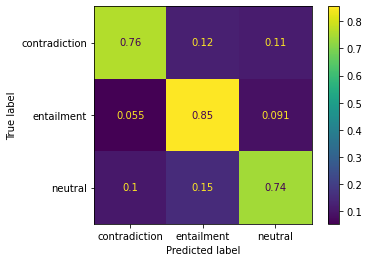

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(corr, pred, normalize='true', labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print('Accuracy:', (corr == pred).mean())

## Inference on custom sentences

In [ ]:
def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    #proba = model.predict(test_data[0])[0]
    proba = model(test_data[0])[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}"
    pred = labels[idx]
    return pred, proba


Check results on some example sentence pairs.

In [ ]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('entailment', ' 0.67')

Check results on some example sentence pairs.

In [ ]:
sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('neutral', ' 0.92')

Check results on some example sentence pairs

In [7]:
sentence1 = "A soccer game with multiple males playing"
sentence2 = "Some men are playing a sport"
check_similarity(sentence1, sentence2)

NameError: ignored